In [1]:
#import des bibliothèques
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import custom_functions as cf
from mpl_toolkits.mplot3d import Axes3D
from sklearn import cluster, metrics, decomposition, preprocessing, manifold
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import random as rd


#Les options suivantes permettent d'afficher toutes les lignes et colonnes voulues lorsqu'on appelle la fonction print
pd.set_option("max_rows", None)
pd.set_option("max_columns", None)

#On importe le jeu de données
data = pd.read_csv('database_clients.csv')

# Visualisation des données

In [2]:
#On jette un oeil à cette database
data.head()

,customer_unique_id,Recence_derniere_cmd,Nombre_commandes,Plusieurs_commandes,Montant_total,Montant_dernier,Mean_review_score,Prix_moyen_articles
0,0000366f3b9a7992bf8c76cfdf3221e2,115.0,1,0,129.90,129.90,5.0,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118.0,1,0,18.90,18.90,4.0,18.90
2,0000f46a3911fa3c0805444483337064,541.0,1,0,69.00,69.00,3.0,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,325.0,1,0,25.99,25.99,4.0,25.99
4,0004aac84e0df4da2b147fca70cf8255,292.0,1,0,180.00,180.00,5.0,180.00


## ACP

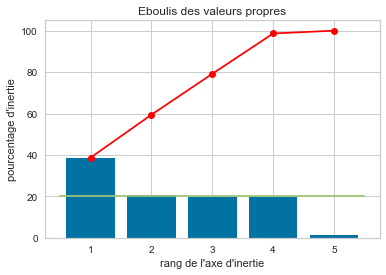

In [3]:
#On va faire une ACP, en ne considérant que les variables qui nous intéressent
colonnes = ['Recence_derniere_cmd', 'Nombre_commandes', 'Montant_dernier', 'Mean_review_score', 'Prix_moyen_articles']
n_comp = len(colonnes)

#On restreint notre database restreinte aux colonnes qui nous intéressent
data_pca = data[colonnes]

#On prépare les données pour l'ACP
data_pca = data_pca.fillna(data_pca.median()) # Il est fréquent de remplacer les valeurs inconnues par la mediane de la variable
X = data_pca.values
features = data_pca.columns

#Centrage et Réduction de nos données
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

#On affiche l'éboulis des valeurs propres
cf.ACP_eboulis(pca, n_comp)

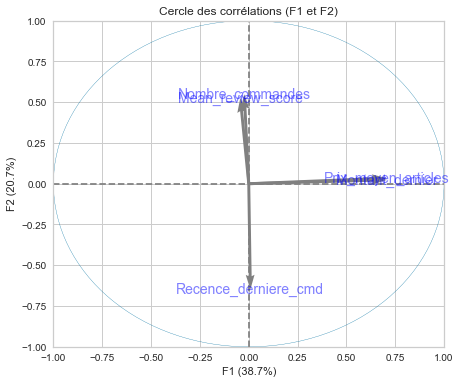

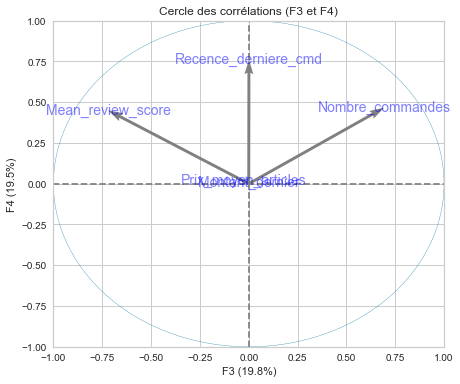

In [4]:
#On va afficher les cercles de corrélations des variables pertinentes
pcs = pca.components_
cf.ACP_cercles_correlation(pcs, n_comp, pca, [(0,1),(2,3)], labels = colonnes)

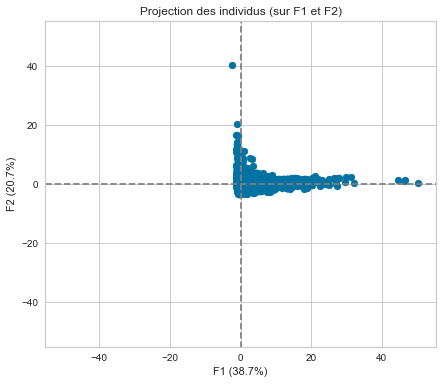

In [5]:
#Projection des individus sur le premier plan factoriel
X_projected = pca.transform(X_scaled)
cf.ACP_plans_factoriels(X_projected, n_comp, pca, [(0,1)])
plt.show()

## t-SNE

In [6]:
#On va réduire la dimension du dataset via l'algorithme t-SNE, qui devrait commencer a séparer nos données 
X_embedded = manifold.TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(X_scaled)

X_embedded.shape

D:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


(95420, 2)

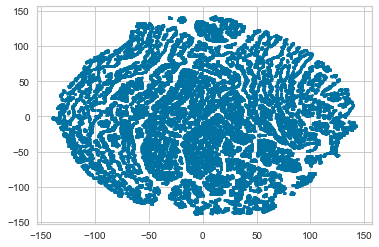

In [7]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], s=4)
plt.show()

La réduction de dimension par t-SNE ne fait pas apparaître de clusters évidents.

# Algorithme k-means

In [8]:
#On isole et standardise les données d'intérêt pour nos modèles de clustering
X = data[colonnes]
X_norm = preprocessing.scale(X)

In [9]:
#On va s'intéresser au k-means, en comparant les coefficients de silhouette pour différentes valeurs de k
silhouettes = []
valeurs_k = range(2,10)
for num_clusters in valeurs_k:
    cls = cluster.KMeans(n_clusters=num_clusters, random_state=42)
    cls.fit(X_norm)
    silh = metrics.silhouette_score(X_norm, cls.labels_)
    silhouettes.append(silh)

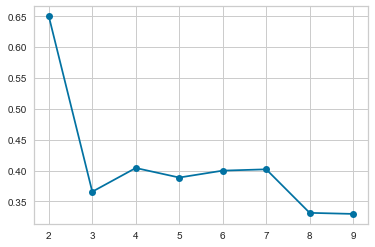

In [10]:
#On affiche le coefficient de silhouette
plt.plot(valeurs_k, silhouettes, marker='o')

In [11]:
#On récupère la "meilleure" valeur de k
N_clusters = valeurs_k[np.argmax(silhouettes)]
print(N_clusters)

2


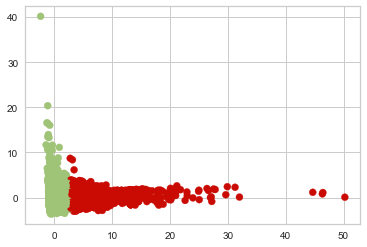

In [12]:
#On affiche nos individus sur le premier plan factoriel, coloriés selon un k-means avec le k optimal calculé précédemment
cls = cluster.KMeans(n_clusters = N_clusters, random_state=42)
cls.fit(X_norm)
colormap = np.array(['r', 'g', 'b', 'm', 'c', 'y', 'k'])
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=colormap[cls.labels_%7])
plt.show()

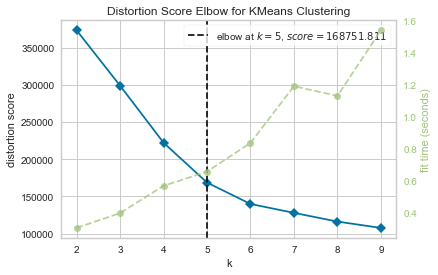

In [13]:
#On va utiliser KElbowVisualizer pour sélectionner k selon la méthode du coude pour le coefficient de distorsion
model = cluster.KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,10))
visualizer.fit(X_norm)
#On récupère la valeur de k optimale selon ce nouveau critère de sélection
N_clusters_bis = visualizer.elbow_value_
visualizer.poof()

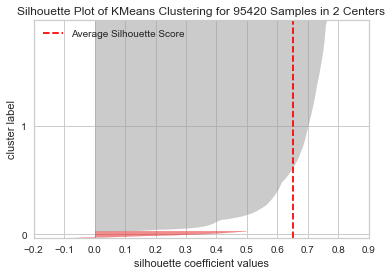

In [14]:
#On va visualiser le coefficient de silhouette de chaque individu, d'abord avec la valeur de k qui maximise ce coefficient
model1 = cluster.KMeans(N_clusters, random_state=42)
visualizer = SilhouetteVisualizer(model1)
visualizer.fit(X_norm) 
visualizer.poof() 

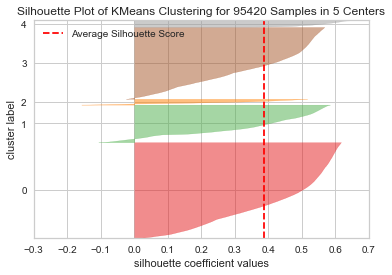

In [15]:
#Même chose mais avec le k sélectionné par la méthode du coude appliquée au coefficient de distorsion des clusters
model2 = cluster.KMeans(N_clusters_bis, random_state=42)
visualizer = SilhouetteVisualizer(model2)

visualizer.fit(X_norm)    # Fit the data to the visualizer
visualizer.poof() 

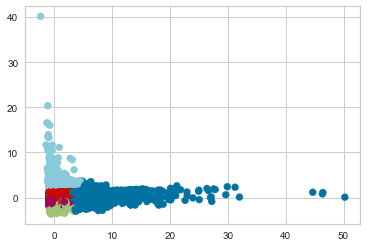

In [16]:
#On affiche nos individus sur le premier plan factoriel, coloriés selon un k-means pour k=5
cls2 = cluster.KMeans(n_clusters = 5, random_state=42)
cls2.fit(X_norm)
colormap = np.array(['r', 'g', 'b', 'm', 'c', 'y', 'k'])
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=colormap[cls2.labels_%7])
plt.show()

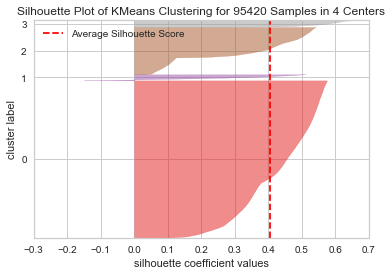

In [17]:
#Dans le modèle RFM la valeur k=4 semblait pertinente, nous allons aussi essayer avec cette valeur
#qui a un coefficient de silhouette raisonnable
model3 = cluster.KMeans(4, random_state=42)
visualizer = SilhouetteVisualizer(model3)

visualizer.fit(X_norm)    # Fit the data to the visualizer
visualizer.poof() 

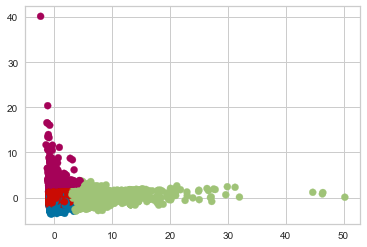

In [18]:
#On affiche nos individus sur le premier plan factoriel, coloriés selon un k-means pour k=4
cls3 = cluster.KMeans(n_clusters = 4, random_state=42)
cls3.fit(X_norm)
colormap = np.array(['r', 'g', 'b', 'm', 'c', 'y', 'k'])
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=colormap[cls3.labels_%7])
plt.show()

In [19]:
#On va créer des fonctions pour afficher la répartition des variables selon les différents clusters obtenus
def repart_variables_clusters(data, features, clustering_labels):
    clustering = pd.Series(clustering_labels, name='clustering')
    temp = pd.concat([data, clustering], axis=1)
    clusters = clustering.unique()
    n = len(clusters)
    f = len(features)
    fig = plt.figure(figsize=(10, 6*f))
    l=0
    for feat in features:
        l=l+1
        ax = fig.add_subplot(f, 1, l)
        donnees = []
        for i in range(n):
            truc = temp[temp['clustering'] == clusters[i]][feat].tolist()
            donnees.append(truc)
        ax.boxplot(donnees, labels=clusters, showfliers=True, flierprops=flierprops, medianprops=medianprops, 
                vert=True, patch_artist=True, showmeans=True, meanprops=meanprops)
        ax.set_title(feat, fontsize=14, fontweight='bold')
    plt.show()

def repart_clusters_variables(data, features, clustering_labels):
    clustering = pd.Series(clustering_labels, name='clustering')
    temp = pd.concat([data, clustering], axis=1)
    temp[features] = (temp[features]-temp[features].min())/(temp[features].max()-temp[features].min())
    clusters = clustering.unique()
    n = len(clusters)
    fig = plt.figure(figsize=(10, 6*n))
    l=0
    for i in range(n):
        l=l+1
        ax = fig.add_subplot(n, 1, l)
        print()
        donnees = []
        for feat in features:
            truc = temp[temp['clustering'] == clusters[i]][feat].tolist()
            donnees.append(truc)
        ax.set_ylim(-0.1,1.1)
        ax.boxplot(donnees, labels=features, showfliers=True, flierprops=flierprops, medianprops=medianprops, 
                vert=True, patch_artist=True, showmeans=True, meanprops=meanprops)
        ax.set_title('Cluster n°{} :'.format(clusters[i]), fontsize=14, fontweight='bold')
    plt.show()
    
#Quelques propriétés graphiques pour rendre les boxplots plus lisibles
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
flierprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'gray'}

D:\Anaconda\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


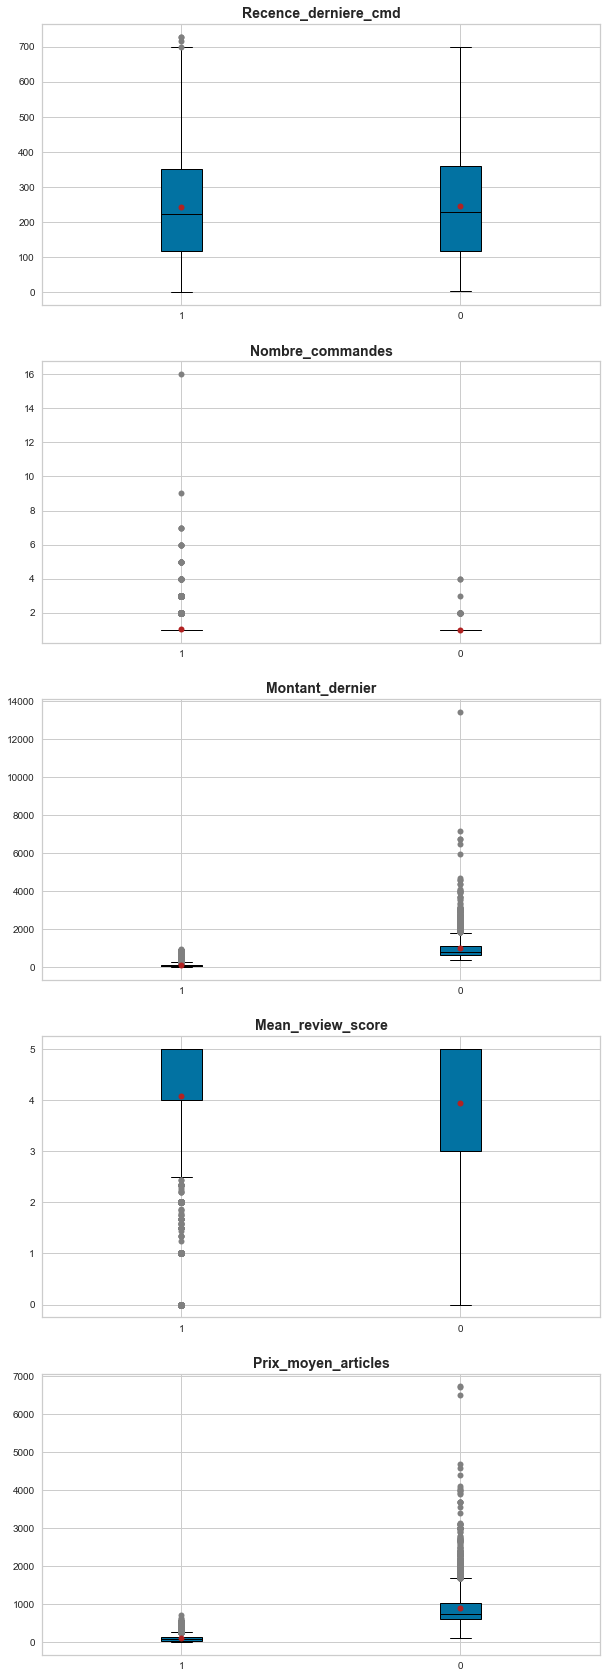

In [20]:
#On affiche les variables selon les différents clusters pour le 1er k-means (méthode silhouette)
repart_variables_clusters(data, colonnes, cls.labels_)

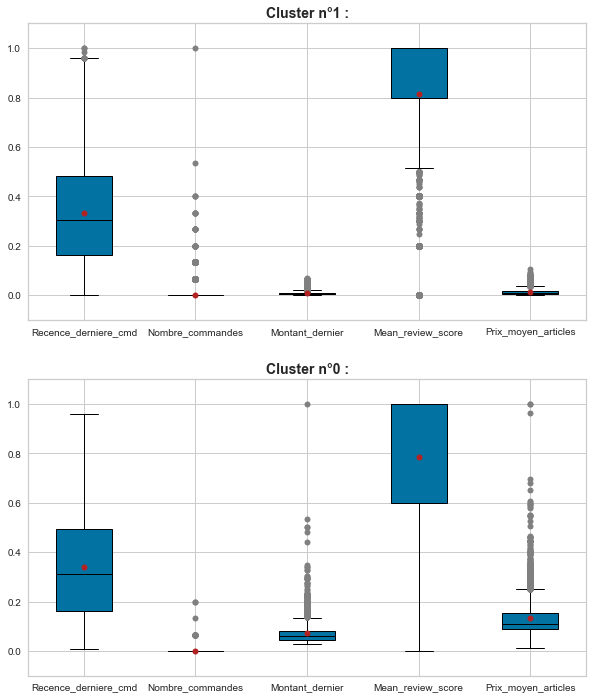

In [21]:
#On affiche la répartition des variables (renormalisées) dans chaque cluster afin d'en déduire une description
#concrète des critères d'appartenance a chaque cluster (toujours pour le 1er k-means)
repart_clusters_variables(data, colonnes, cls.labels_)

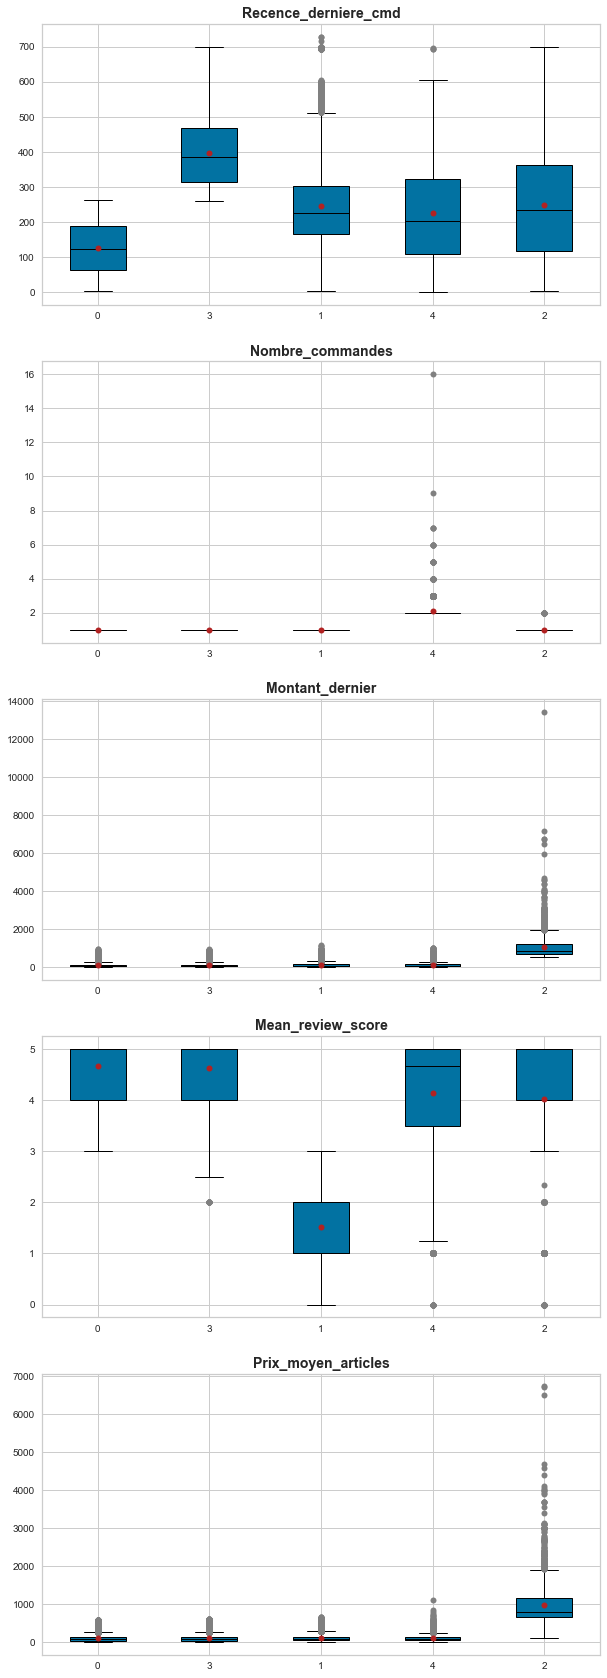

In [22]:
#On affiche les variables selon les différents clusters pour le 2nd k-means (méthode distortion)
repart_variables_clusters(data, colonnes, cls2.labels_)

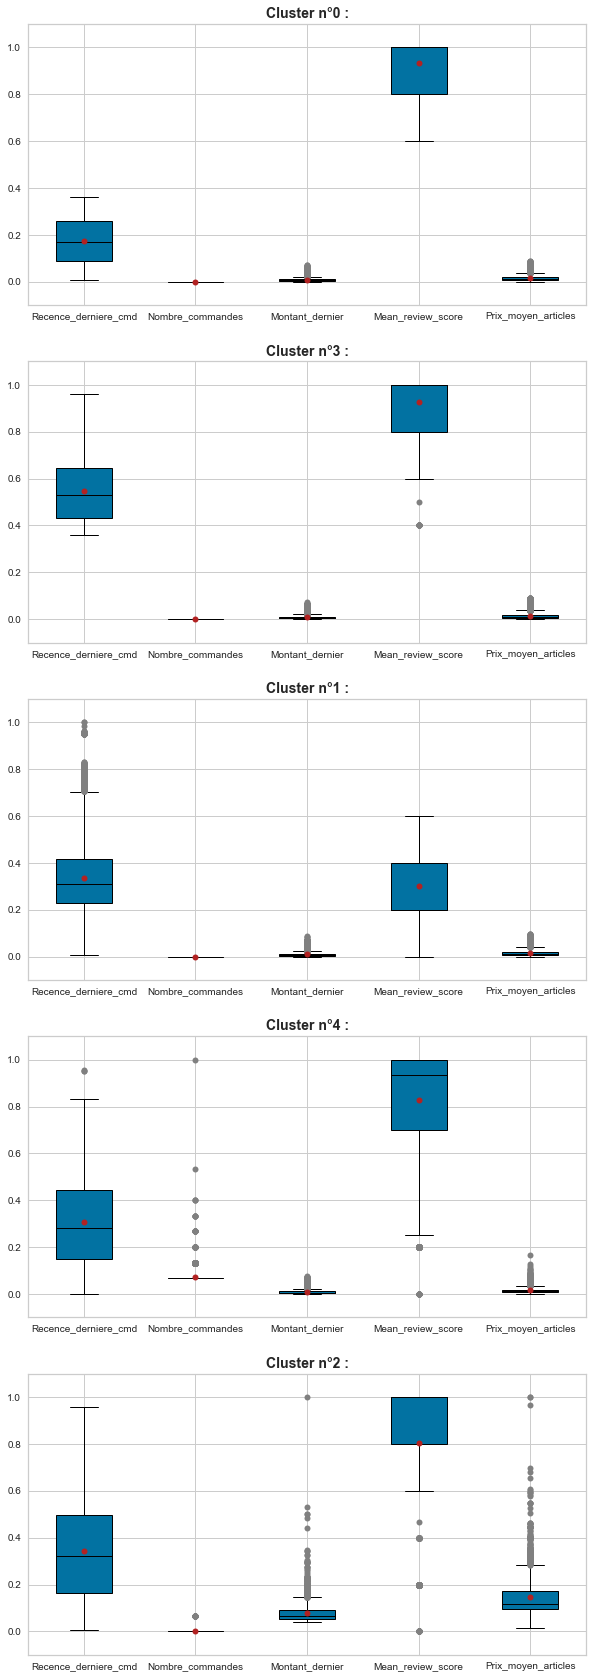

In [23]:
#On affiche la répartition des variables (renormalisées) dans chaque cluster afin d'en déduire une description
#concrète des critères d'appartenance a chaque cluster (toujours pour le 2nd k-means)
repart_clusters_variables(data, colonnes, cls2.labels_)

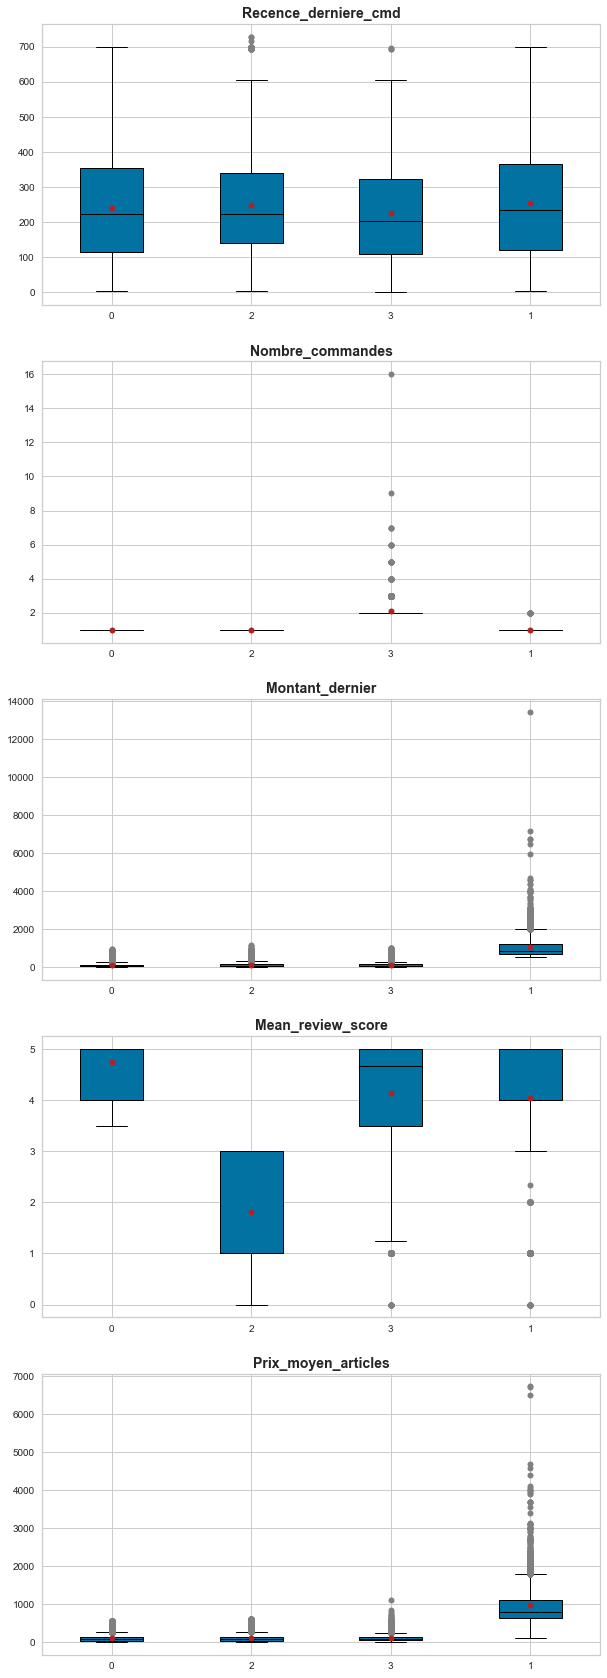

In [24]:
#On affiche les variables selon les différents clusters pour le k-means avec k=4
repart_variables_clusters(data, colonnes, cls3.labels_)

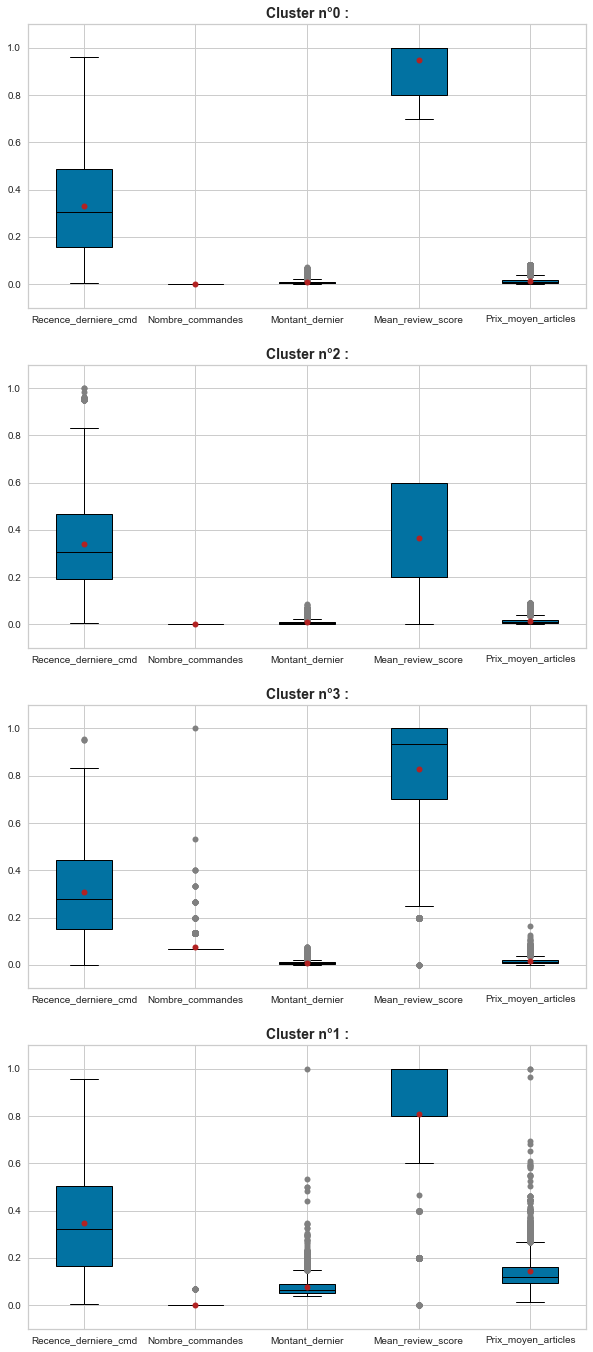

In [25]:
#On affiche la répartition des variables (renormalisées) dans chaque cluster afin d'en déduire une description
#concrète des critères d'appartenance a chaque cluster (toujours pour le 2nd k-means)
repart_clusters_variables(data, colonnes, cls3.labels_)

On va refaire la même procédure sur les données traitées par l'algorithme t-SNE.

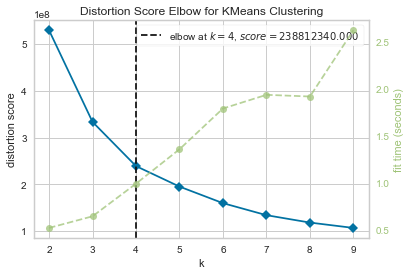

In [26]:
#On va chercher un k-means adapté a la réduction faite par le t-SNE
model = cluster.KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,10))
visualizer.fit(X_embedded)
#On récupère la valeur de k optimale selon ce nouveau critère de sélection
N_clusters_tSNE = visualizer.elbow_value_
visualizer.poof()

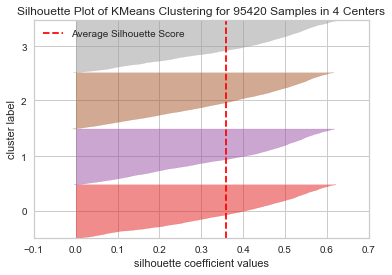

In [27]:
#Observons le coefficient de silhouette obtenu
model4 = cluster.KMeans(N_clusters_tSNE, random_state=42)
visualizer = SilhouetteVisualizer(model4)

visualizer.fit(X_embedded)    # Fit the data to the visualizer
visualizer.poof() 

D:\Anaconda\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


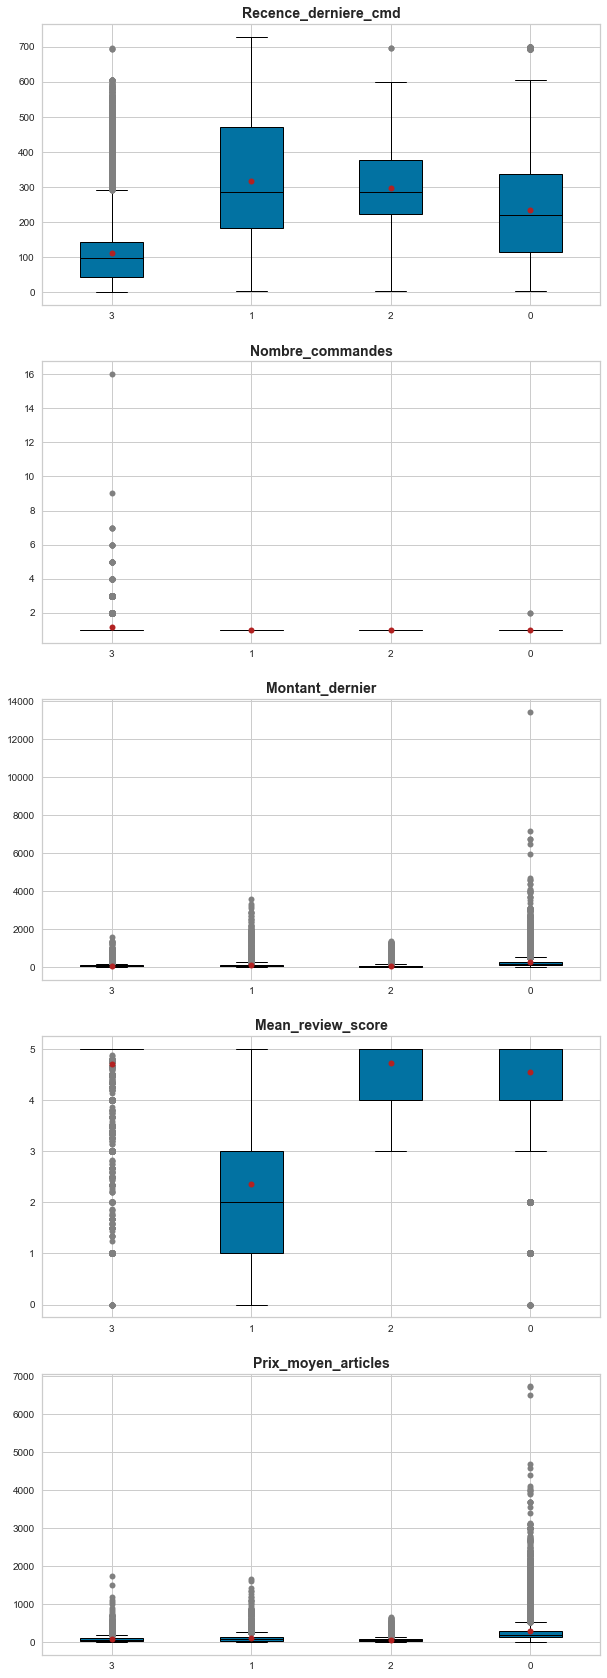

In [28]:
#On affiche les variables selon les différents clusters trouvés via cette méthode
cls4 = cluster.KMeans(n_clusters = N_clusters_tSNE, random_state=42)
cls4.fit(X_embedded)
repart_variables_clusters(data, colonnes, cls4.labels_)

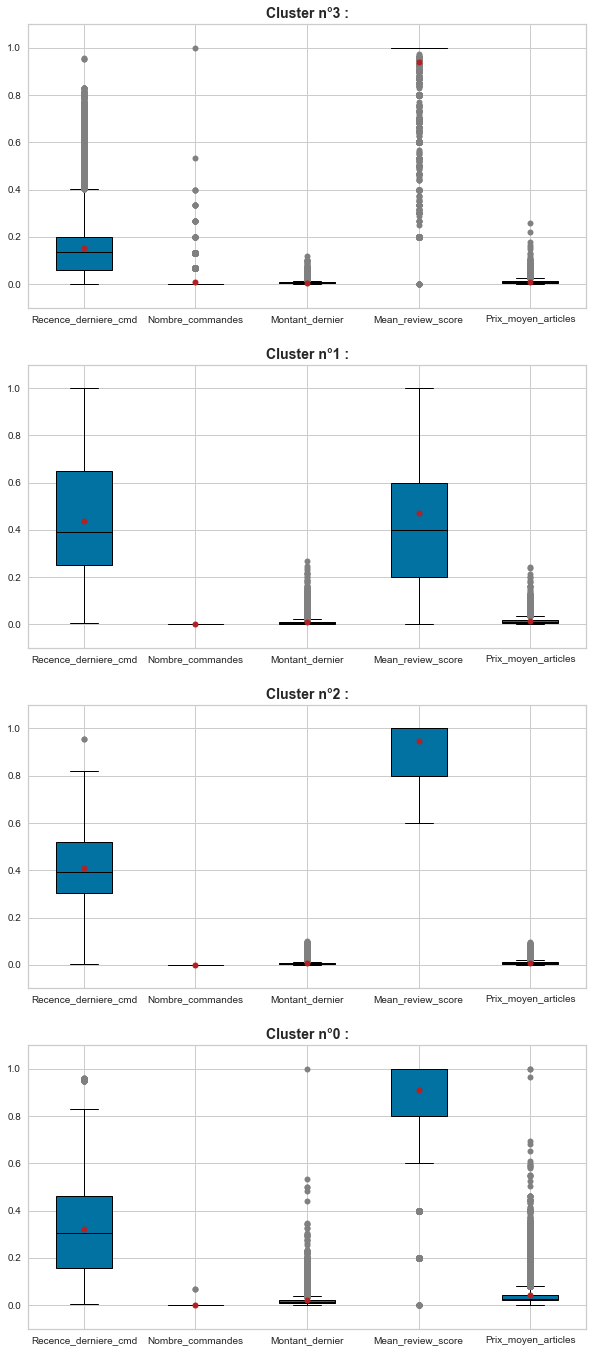

In [29]:
#On affiche la répartition des variables (renormalisées) dans chaque cluster afin d'en déduire une description
#concrète des critères d'appartenance a chaque cluster
repart_clusters_variables(data, colonnes, cls4.labels_)

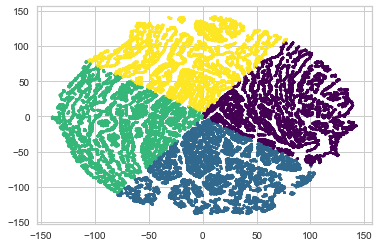

In [30]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], s=4, c=cls4.labels_, cmap='viridis')
plt.show()

Le coefficient de silhouette obtenu et la répartition des individus dans chaque cluster est très proche du k-means à 4 clusters sans t-SNE.

# DBScan

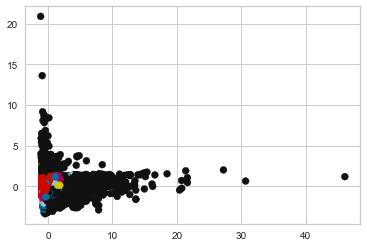

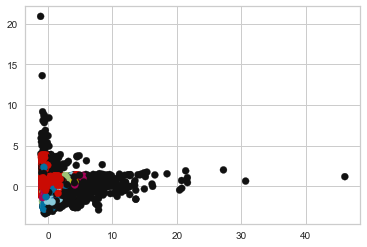

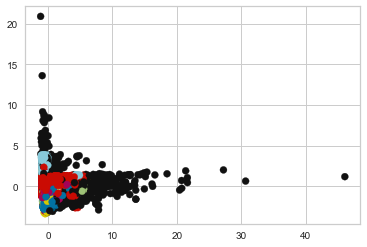

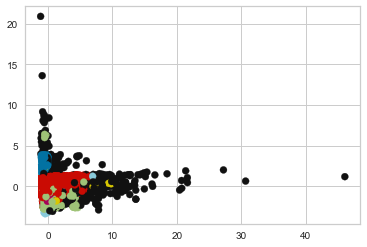

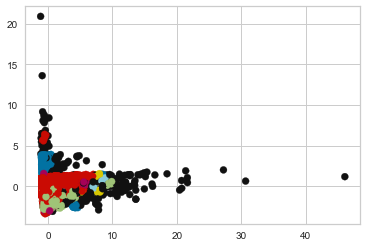

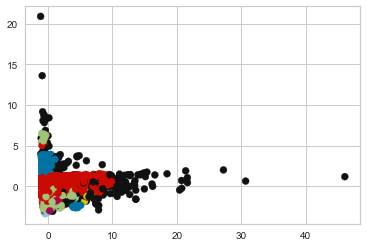

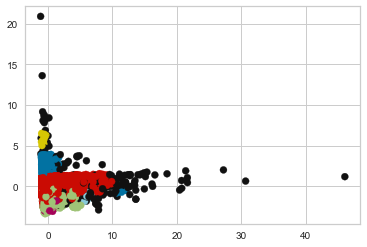

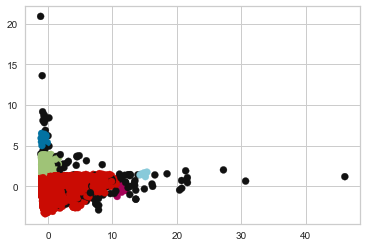

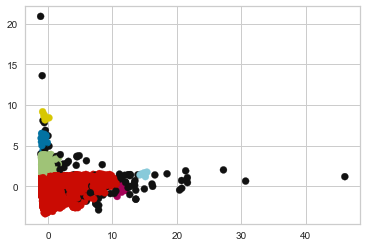

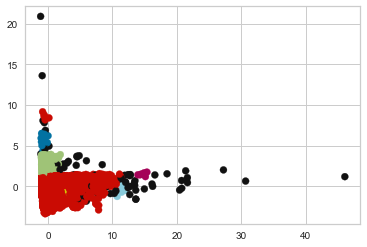

In [31]:
#On va utiliser l'algorithme DBScan (fourni par sklearn) pour essayer d'obtenir un clustering plus pertinent

#Pour identifier les bons hyperparamètres on va réduire le temps de calcul en travaillant sur un échantillon réduit
N = data.shape[0]
proportion = 0.2
rd.seed(1)
sample_index = rd.sample(data.index.tolist(), int(proportion*N))
data_sample = data.loc[sample_index]
X = data_sample[colonnes]
X_norm = preprocessing.scale(X)
colors = ['r', 'g', 'b', 'm', 'c', 'y']
colormap = np.array((colors*20) + ['k'])

#Projection des individus sur les 2 plans factoriels
X_sample_projected = pca.transform(X_norm)

#On va comparer les coefficients de silhouette et le nombre de clusters pour différentes valeurs de epsilon
silhouettes = []
n_clusters = []
n_bruits = []
valeurs_eps = np.linspace(0.1, 1, 10)
for epsilon in valeurs_eps:
    # Segmentation à l'aide d'un dbscan'
    dbscan = cluster.DBSCAN(eps=epsilon, min_samples=5).fit(X_norm)
    
    clusters = dbscan.labels_.tolist()
    n_clusters.append(max(clusters) + 1)
    
    noise_labels = [i for i,x in enumerate(clusters) if x==-1]
    n_bruits = len(noise_labels)
    
    X_calc = np.delete(X_norm, noise_labels, 0)
    
    for index in sorted(noise_labels, reverse=True):
        del clusters[index]

    silhouettes.append(metrics.silhouette_score(X_calc, clusters, metric='euclidean'))
    
    
    # Visualisation du résultat 
    plt.scatter(X_sample_projected[:, 0], X_sample_projected[:, 1], c=colormap[dbscan.labels_])
    plt.show()


Coefficients de silhouette


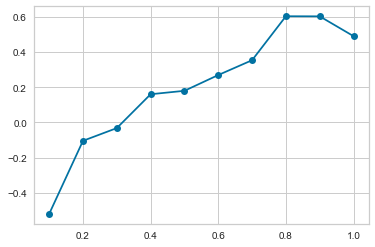

Nombre de clusters


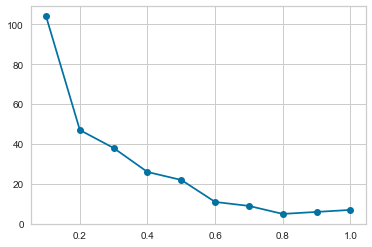

In [32]:
#On affiche les coefficients de silhouette selon epsilon
print('Coefficients de silhouette')
plt.plot(valeurs_eps, silhouettes, marker='o')
plt.show()
#On affiche le nombre de clusters selon epsilon
print('Nombre de clusters')
plt.plot(valeurs_eps, n_clusters, marker='o')
plt.show()

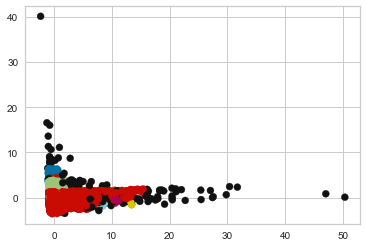

DBScan avec epsilon = 0.8, 8 clusters détectés et 221 individus mis de côté. Coefficient de silhouette moyen : 0.41878510598587926


In [33]:
#On va appliquer le meilleur DBScan
epsilon = 0.8

#On utlisera davantage de données (50% de la database), mais pas la totalité (l'ordinateur ne parvient pas a suivre)
N = data.shape[0]
proportion = 0.5
rd.seed(24)
sample_index = rd.sample(data.index.tolist(), int(proportion*N))
data_sample = data.loc[sample_index]
X = data_sample[colonnes]
X_norm = preprocessing.scale(X)

#Projection des individus sur les 2 plans factoriels
X_sample_projected = pca.transform(X_norm)

dbscan = cluster.DBSCAN(eps=epsilon, min_samples=5).fit(X_norm)
    
clusters = dbscan.labels_.tolist()
n_clusters = max(clusters) + 1 
noise_labels = [i for i,x in enumerate(clusters) if x==-1]
n_bruits = len(noise_labels)
X_calc = np.delete(X_norm, noise_labels, 0)  
for index in sorted(noise_labels, reverse=True):
    del clusters[index]
coeff_sil = metrics.silhouette_score(X_calc, clusters, metric='euclidean')
    
plt.scatter(X_sample_projected[:, 0], X_sample_projected[:, 1], c=colormap[dbscan.labels_])
plt.show()

print("DBScan avec epsilon = {}, {} clusters détectés et {} individus mis de côté. Coefficient de silhouette moyen : {}"\
      .format(epsilon, n_clusters, n_bruits, coeff_sil))

D:\Anaconda\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


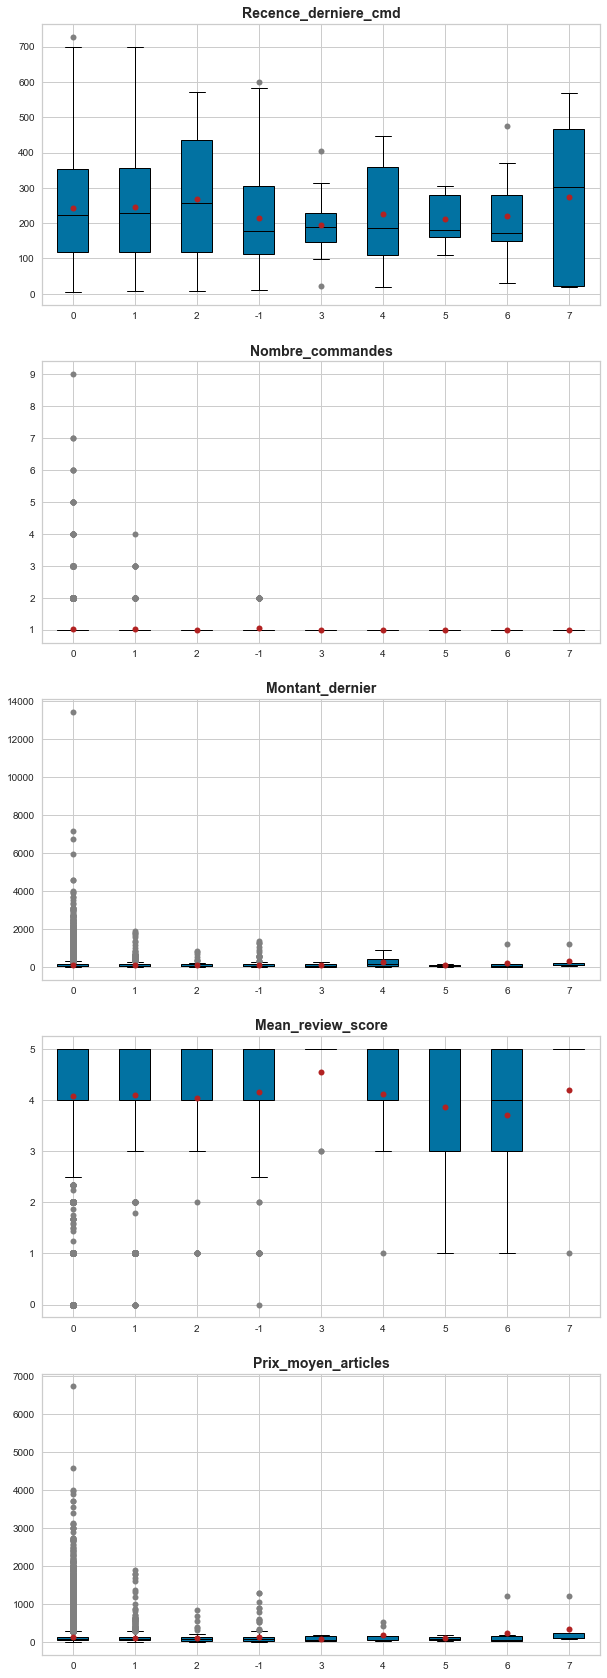

In [34]:
#On affiche les variables selon les différents clusters pour le dbscan
repart_variables_clusters(data, colonnes, dbscan.labels_)

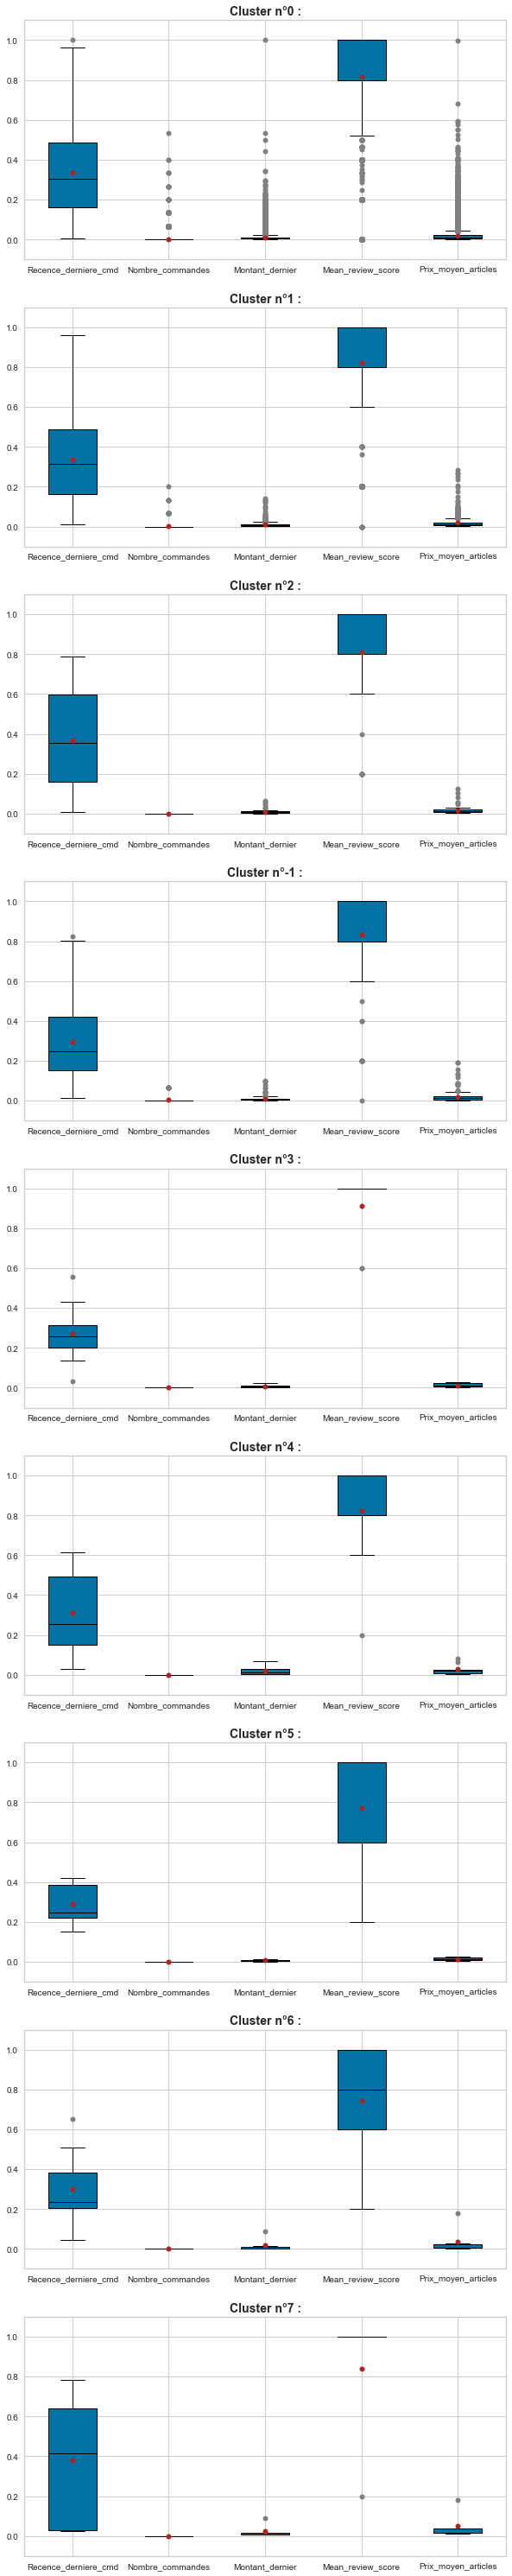

In [35]:
#On affiche la répartition des variables (renormalisées) dans chaque cluster afin d'en déduire une description
#concrète des critères d'appartenance a chaque cluster (toujours pour le dbscan)
repart_clusters_variables(data, colonnes, dbscan.labels_)

# CAH

In [36]:
#On va essayer avec une CAH, toujours dans le but d'obtenir une segmentation aussi pertinente que possible
#Pour la CAH on va devoir travailler sur un sous-échantillon réduit
N = data.shape[0]
proportion = 0.2
rd.seed(42)
sample_index = rd.sample(data.index.tolist(), int(proportion*N))
data_sample = data.loc[sample_index]
X = data_sample[colonnes]
X_norm = preprocessing.scale(X)

#Projection des individus sur les 2 plans factoriels
X_sample_projected = pca.transform(X_norm)

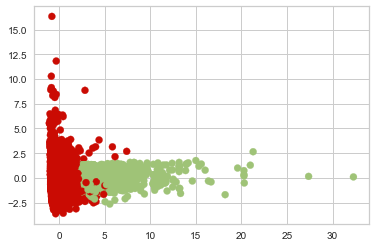

coefficient de silhouette pour 2 clusters : 0.6336668371849293


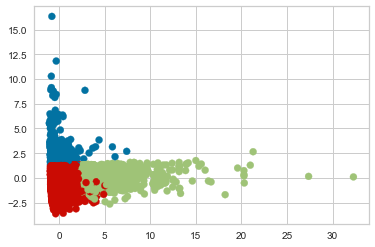

coefficient de silhouette pour 3 clusters : 0.6388127012289994


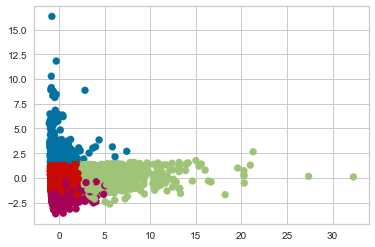

coefficient de silhouette pour 4 clusters : 0.4348231165430408


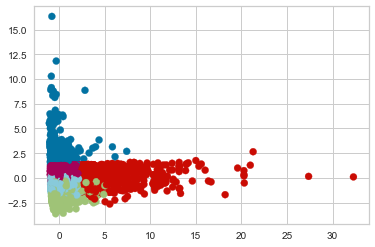

coefficient de silhouette pour 5 clusters : 0.364374068159376


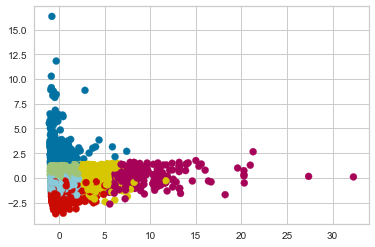

coefficient de silhouette pour 6 clusters : 0.3675256423907716


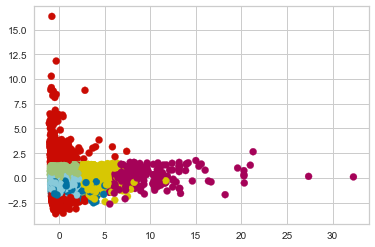

coefficient de silhouette pour 7 clusters : 0.3604896030664954


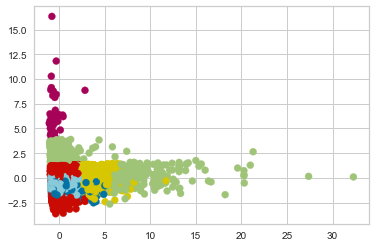

coefficient de silhouette pour 8 clusters : 0.36301282136454627


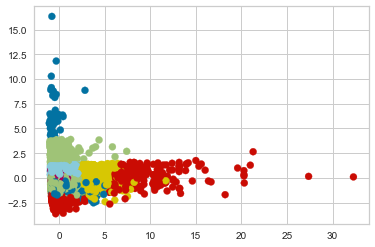

coefficient de silhouette pour 9 clusters : 0.3121642415483547


In [37]:
#On va comparer les coefficients de silhouette pour différentes valeurs de k, le nombre de clusters
silhouettes = []
valeurs_k = range(2,10)
for k in valeurs_k:
    # Segmentation à l'aide d'une CAH
    y_pred = cluster.AgglomerativeClustering(n_clusters = k).fit_predict(X_norm)

    # Visualisation du résultat
    plt.scatter(X_sample_projected[:, 0], X_sample_projected[:, 1], c=colormap[y_pred])
    plt.show()
    
    temp = metrics.silhouette_score(X_norm, y_pred, metric='euclidean')
    print("coefficient de silhouette pour {} clusters : {}".format(k, temp))
    silhouettes.append(temp)

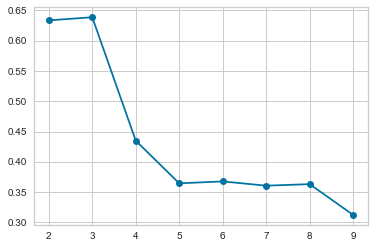

In [38]:
#On affiche les coefficients de silhouette selon k
plt.plot(valeurs_k, silhouettes, marker='o')

In [39]:
#On récupère le nombre optimal de clusters pour notre CAH
N_clusters_cah = valeurs_k[np.argmax(silhouettes)]
print(N_clusters_cah)

3


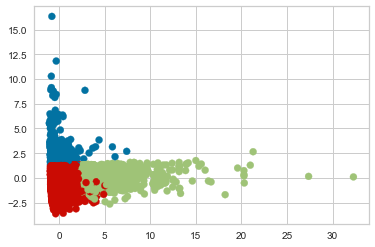

coefficient de silhouette pour 3 clusters : 0.6388127012289994


In [40]:
# Segmentation à l'aide d'une CAH avec le nombre optimal de clusters (selon le coefficient de silhouette)
y_pred = cluster.AgglomerativeClustering(n_clusters = N_clusters_cah).fit_predict(X_norm)

# Visualisation du résultat
plt.scatter(X_sample_projected[:, 0], X_sample_projected[:, 1], c=colormap[y_pred])
plt.show()

silhouette = metrics.silhouette_score(X_norm, y_pred, metric='euclidean')
    
print("coefficient de silhouette pour {} clusters : {}".format(N_clusters_cah, silhouette))

D:\Anaconda\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


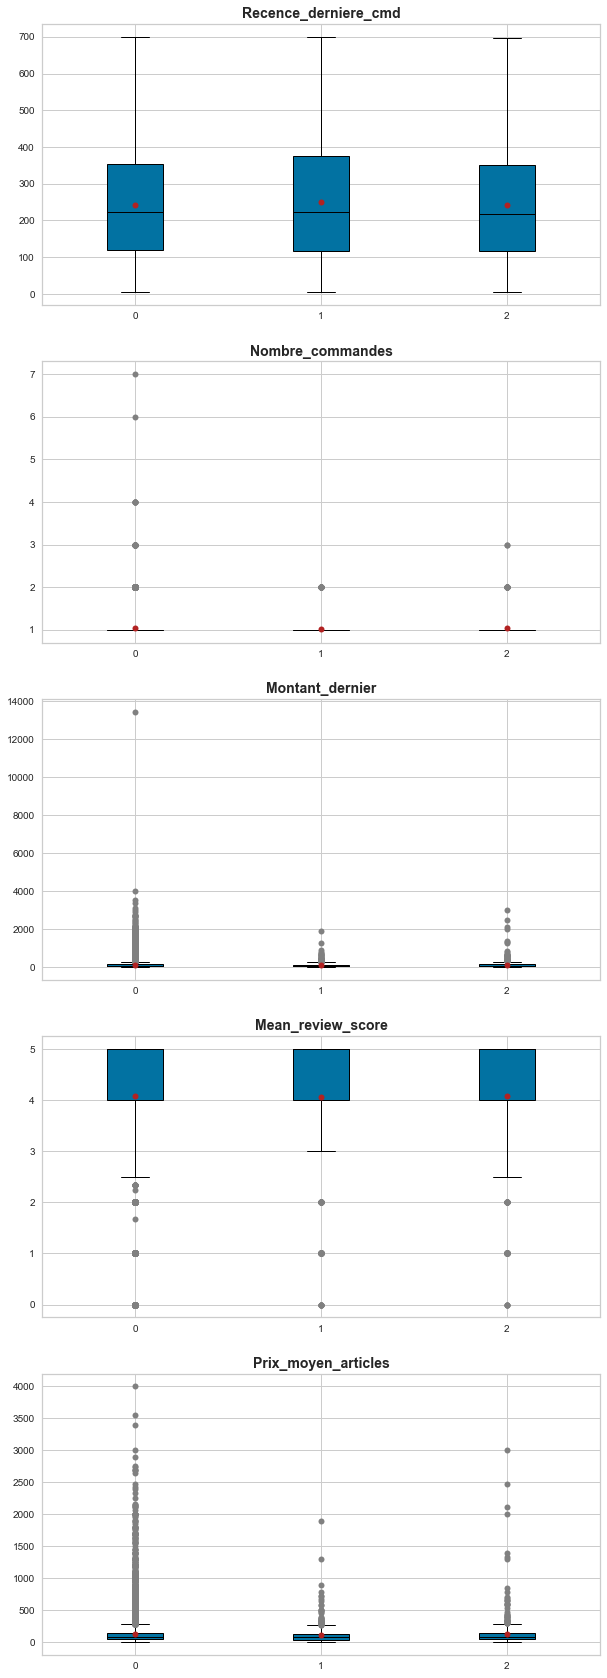

In [41]:
#On affiche les variables selon les différents clusters pour la cah
repart_variables_clusters(data, colonnes, y_pred)

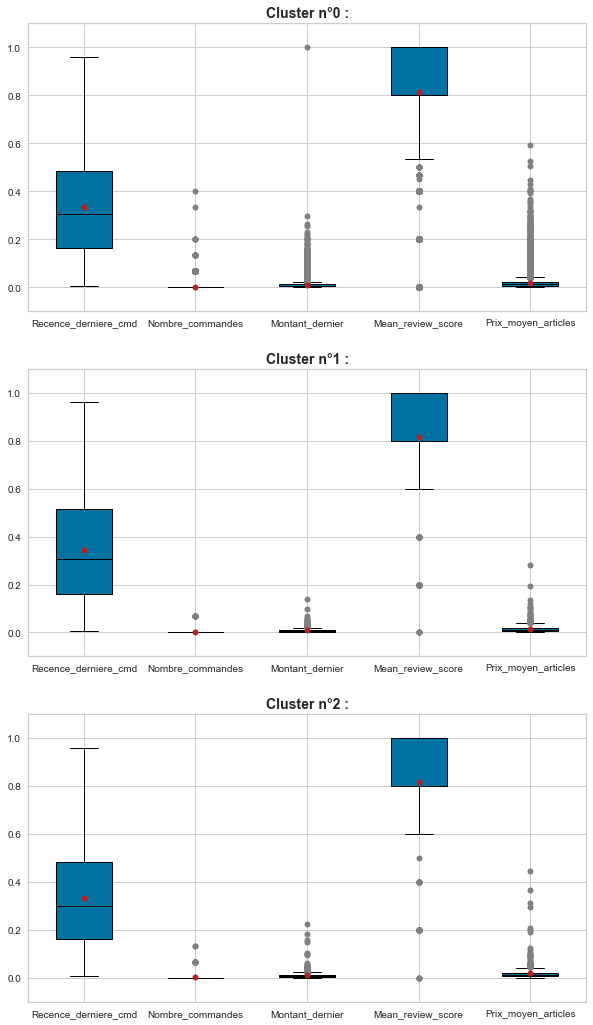

In [42]:
#On affiche la répartition des variables (renormalisées) dans chaque cluster afin d'en déduire une description
#concrète des critères d'appartenance a chaque cluster (toujours pour la cah)
repart_clusters_variables(data, colonnes, y_pred)

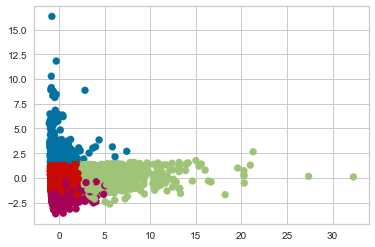

coefficient de silhouette pour 4 clusters : 0.4348231165430408


In [43]:
# On va aussi essayer également avec 4 clusters, pour voir si la description des clusters obtenus est plus pertinente
N_clusters_cah = 4
y_pred = cluster.AgglomerativeClustering(n_clusters = N_clusters_cah).fit_predict(X_norm)

# Visualisation du résultat
plt.scatter(X_sample_projected[:, 0], X_sample_projected[:, 1], c=colormap[y_pred])
plt.show()

silhouette = metrics.silhouette_score(X_norm, y_pred, metric='euclidean')
    
print("coefficient de silhouette pour {} clusters : {}".format(N_clusters_cah, silhouette))

D:\Anaconda\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


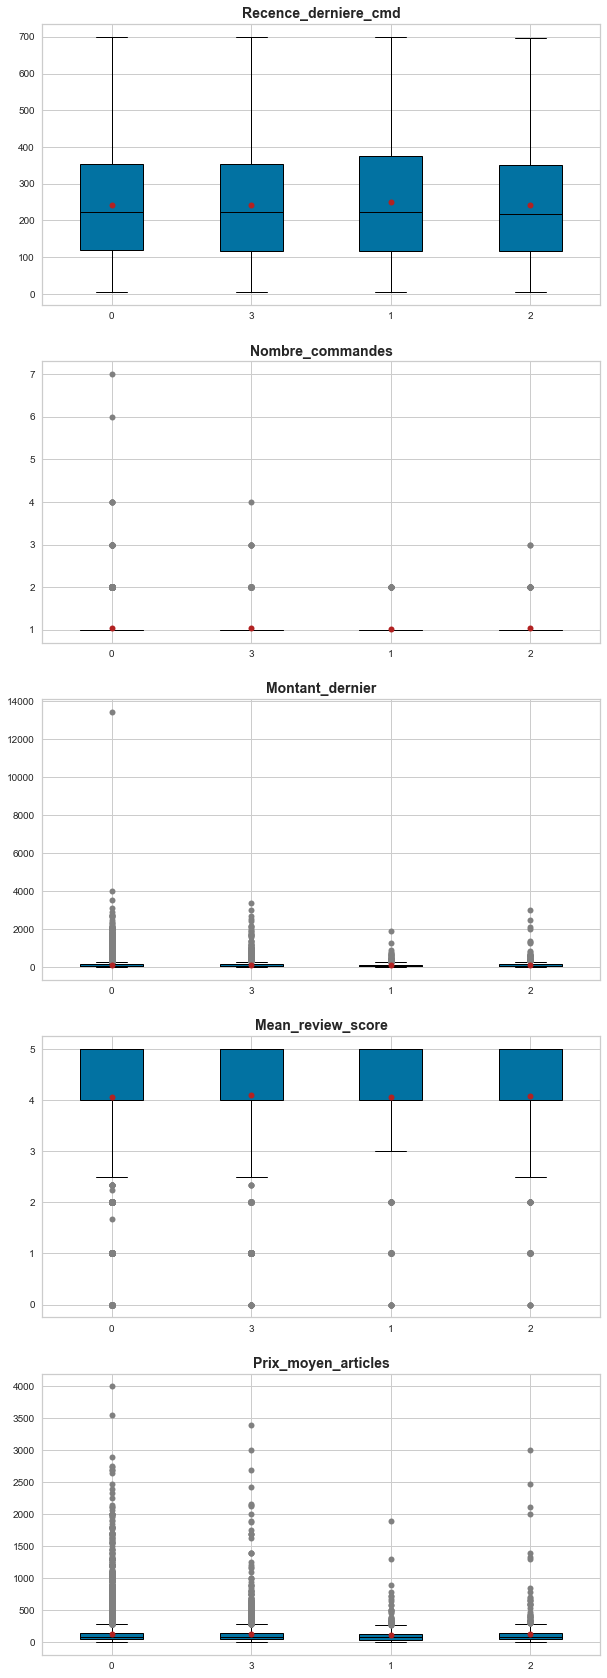

In [44]:
#On affiche les variables selon les différents clusters pour la cah
repart_variables_clusters(data, colonnes, y_pred)

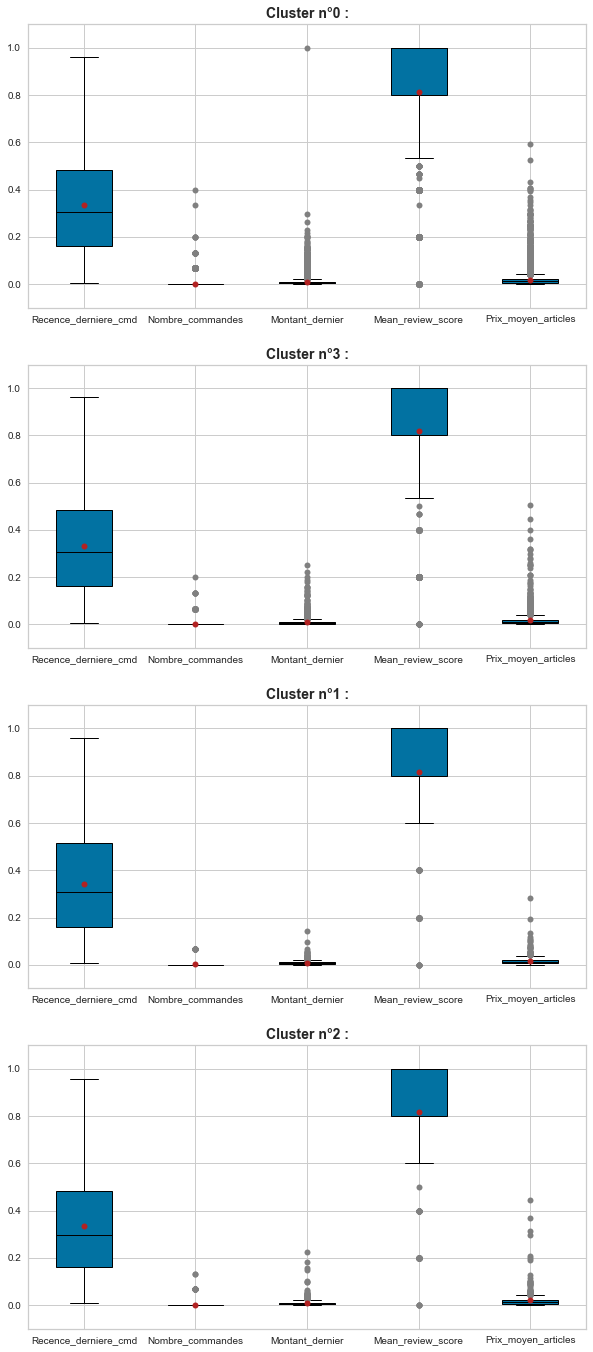

In [45]:
#On affiche la répartition des variables (renormalisées) dans chaque cluster afin d'en déduire une description
#concrète des critères d'appartenance a chaque cluster (toujours pour la cah)
repart_clusters_variables(data, colonnes, y_pred)

# Conclusions

Pour l'algorithme k-means, la valeur de $k$ pertinente serait $k=4$ ($k=2$ génère trop peu de clusters), qui amène un coefficient de silhouette moyen d'environ $0,40$. Les répartitions dans les différents clusters peuvent s'expliquer directement à l'aide des variables. L'algorithme t-SNE n'améliore pas significativement l'efficacité du k-means.

Pour l'algorithme DBScan, le paramètre retenu est $\epsilon = 0.8$, qui détecte $8$ clusters. Le coefficient de silhouette moyen obtenu est d'environ $0,42$. En revanche il semble difficile de décrire simplement les différents clusters à l'aide des variables utilisées.

Pour l'algorithme CAH, il semblerait que le nombre de clusters optimal soit $k=3$, avec un coefficient de silhouette moyen de $0,64$ mais les trois clusters sont difficiles à différencier. La CAH à $4$ clusters abaisse grandement le coefficient de silhouette ($0,45$) malheureusement sans fournir une segmentation plus compréhensible.

Nous retiendrons donc l'algorithme k-means avec k=4.